In [1]:
from networkx.algorithms.bipartite.basic import color
from numpy import cos, sin
from matplotlib import pyplot as plt
import numpy as np

## Functions

get_velocity adds noise to the velocity each episode (when it's called). Set noise_velocity to 0 for no noise (noise of 0)
kinematic_model implements the kinematic model from the lecture
odometry_sensor is our sensor which gets the noisy velocity and adds more noise (noise_odometry) to the sensor reading. This is what our robot sees.
simulate is our main function. Here the number of episodes and steps as well as step_size_robot (to make the updates more frequent in the graphs), axis_length, noise, initial velocity, drive1_in_circles and correction (with the gain_k) can be set. So task a), b) and c) can be simulated using this.
plot_trajectories plots the trajectory of the robot(s) after simualtion - so not live. Here you can decide if the estimated position should be displayed as well (using show_estimate) and set the x-axis and y-axis range (use tuples, e.g. (0, 30)).
plot_final_position_histogram is the 2d histogram we are supposed to plot. It shows the difference of the estimate in regards to the true position of the robot. If the noise_odometry is set to 0, the histogram will only show a square at (0,0). It is NOT in regards to the perfect position (as) if the robot had 0 noise in velocity!

In [2]:
# Get velocity (with noise if needed)
def get_velocity(noise_strength, velocity):
    # add some noise if you want
    noise = np.random.normal(0, noise_strength, 2)
    return [velocity[0]+noise[0], velocity[1]+noise[1]]
# Implemted kinematic model of the lecture
def kinematic_model(state, v_l, v_r, axisLength, dt):
    # equation for kinematic model
    # update real state of the robot
    state[2] += (v_r - v_l) / axisLength * dt
    state[0] += (0.5 * cos(state[2]) * v_l + 0.5 * cos(state[2]) * v_r) * dt
    state[1] += (0.5 * sin(state[2]) * v_l + 0.5 * sin(state[2]) * v_r) * dt
    # return state of the robot
    return state
# calculate the odometry of the robot - where do we think we are?
def odometry_sensor(state_1, state_2, estimate, noise_strength):
    noise = np.random.normal(0, noise_strength, 3)
    return [estimate[0] + state_2[0] - state_1[0] + noise[0], estimate[1] + state_2[1] - state_1[1] + noise[1], estimate[2] + state_2[2] - state_1[2] + noise[2]], noise

def simulate(noise_velocity = 0, noise_odometry = 0, velocity = [1.0, 1.0], drive_in_circles = False, correction = False, gain_k = 0.2, axis_length = 1, steps = 1000, episodes = 100, step_size_robot = 1.0):
    # for visualization purposes
    x_errors, y_errors = [], []
    all_true_trajectories = []
    all_estimated_trajectories = []
    # If we want to drive in a circle using the boolean
    if drive_in_circles:
        velocity = [velocity[0], velocity[1]*0.5]
    # To ensure a reset of the velocity after each episode
    original_velocity = velocity.copy()
    for _ in range(episodes):
        # states represent position and heading
        estimated_state = [0.0, 0.0, 0.0]
        correct_state = [0.0, 0.0, 0.0]
        true_traj = [correct_state[:2]]
        est_traj = [estimated_state[:2]]
        # Get the original velocity when an episode starts
        velocity = original_velocity.copy()
        for _ in range(steps):
            # update velocity
            velocity = get_velocity(noise_velocity, velocity)
            # Get position (and estimation)
            previous_optimal_state = correct_state.copy()
            correct_state = kinematic_model(correct_state, velocity[0], velocity[1], axis_length, step_size_robot)
            estimated_state, _noise = odometry_sensor(previous_optimal_state, correct_state, estimated_state, noise_odometry)

            true_traj.append(correct_state[:2])
            est_traj.append(estimated_state[:2])

            # P control
            if correction:
                velocity[0] += (original_velocity[0] - velocity[0]) * gain_k + _noise[0]
                velocity[1] += (original_velocity[1] - velocity[1]) * gain_k + _noise[1]
            previous_velocity = velocity.copy()

        # x_errors.append(abs(round(estimated_state[0], 5) - round(optimal_state[0], 5)))
        x_errors.append((round(estimated_state[0], 5) - round(correct_state[0], 5)))
        # y_errors.append(abs(round(estimated_state[1], 5) - round(optimal_state[1], 5)))
        y_errors.append((round(estimated_state[1], 5) - round(correct_state[1], 5)))
        all_true_trajectories.append(true_traj)
        all_estimated_trajectories.append(est_traj)
    return x_errors, y_errors, all_true_trajectories, all_estimated_trajectories

# Visualizations
# Plot the trajectory of the robot(s)
def plot_trajectories(true_trajs, est_trajs, show_estimate = False, xlim=None, ylim=None):
    plt.figure(figsize=(10, 10))
    text_displayed = "Trajectories"
    colors = plt.cm.jet(np.linspace(0, 1, len(true_trajs)))
    for i in range(len(true_trajs)):
        true = np.array(true_trajs[i])
        est = np.array(est_trajs[i])
        plt.plot(true[:, 0], true[:, 1], label=f'True Traj {i+1}', linestyle='-', alpha=0.6, color=colors[i])
        if show_estimate:
            plt.plot(est[:, 0], est[:, 1], label=f'Est Traj {i+1}', linestyle='--', alpha=0.6, color=colors[i])
            text_displayed = "True vs Estimated Trajectories"
        plt.scatter(true[0, 0], true[0, 1], color='black', marker='o')  # Start point
    plt.title(text_displayed)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis('equal')
    if xlim: plt.xlim(xlim)
    if ylim: plt.ylim(ylim)
    # plt.legend()
    plt.grid(True)
    plt.show()
# Plot the 2-d histogram
def plot_final_position_histogram(x_errors, y_errors, xlim=None, ylim=None):
    plt.figure(figsize=(6, 6))
    plt.hist2d(x_errors, y_errors, bins=30, cmap='Blues')
    plt.xlabel("X error")
    plt.ylabel("Y error")
    plt.title("2-Dimensional Histogram")
    plt.colorbar(label='Frequency')
    if xlim: plt.xlim(xlim)
    if ylim: plt.ylim(ylim)
    plt.grid(True)
    plt.show()

### a) Robot drives in a straight line along the x-axis starting at (0,0). The kinematic model is used to update the position. The sensor is used to calculate the odometry (estimated position). In this case the noise is 0 so the estimate and correct position are the same and the robot drives on the x-axis.




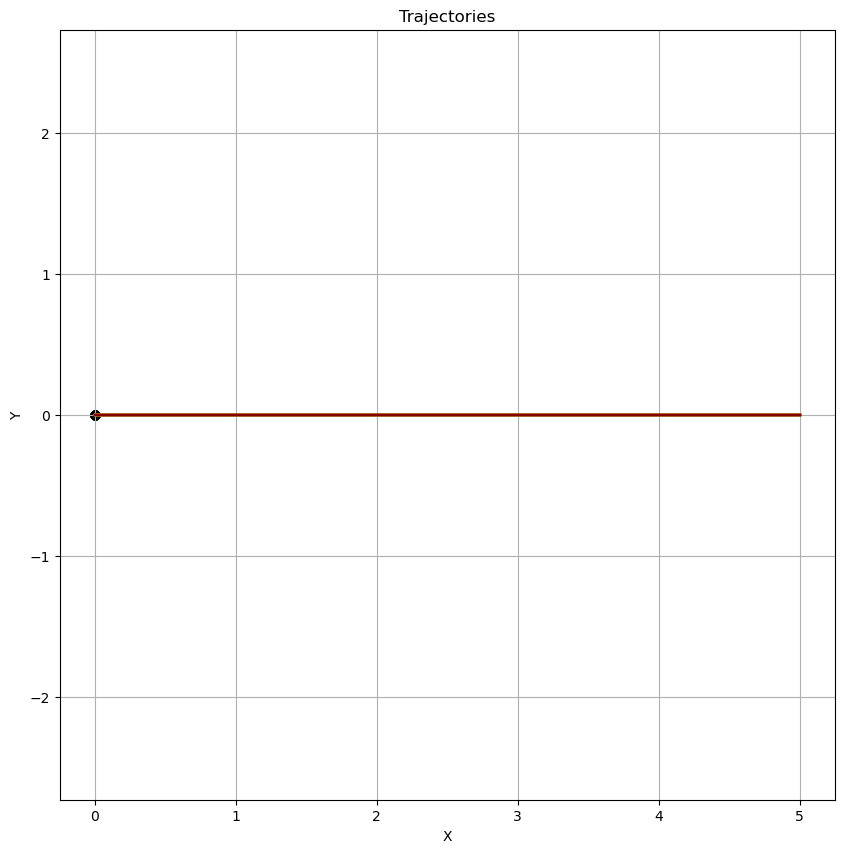

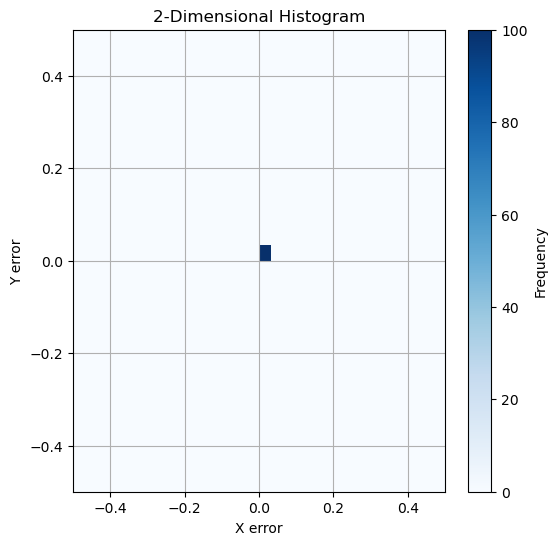

In [3]:
x_err, y_err, true_trajs, est_trajs = simulate(
    episodes=100,
    steps=20,
    step_size_robot=0.25,
)

plot_trajectories(true_trajs, est_trajs)
plot_final_position_histogram(x_err, y_err)

### b) We introduce noise to the velocity using a normal distribution. The mean is set to 0 and the std can be adjusted using noise_velocity. The noise for v_l and v_r are calculated separately. The odometry is still implemented and since the noise_odometry is 0, the estimate is the correct position. We also introduce drive_in_circles where the velocity is set to [velocity[0], velocity[1]*0.5]. Instead it is also possible to just set the velocity when the function is called. Then the boolean/flag does not need to be set.

#### 1 - Straight line with velocity noise

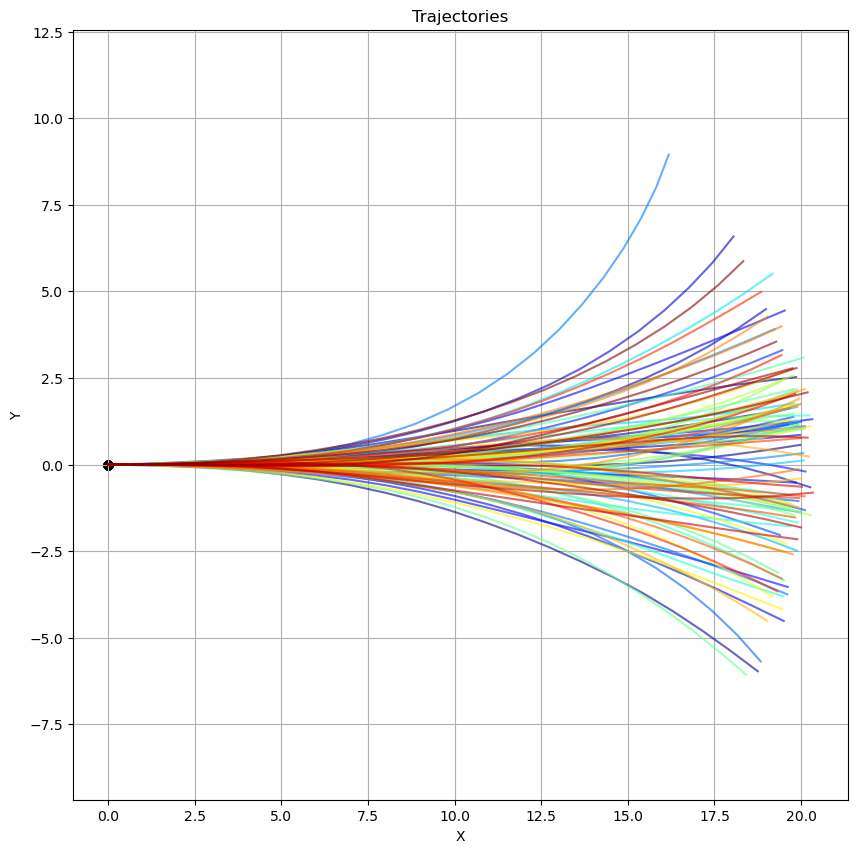

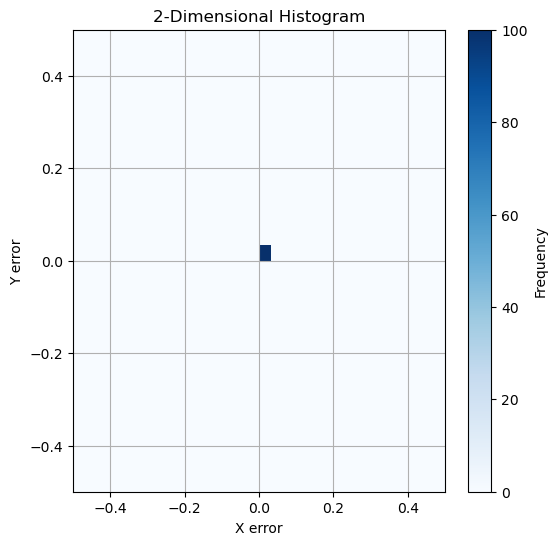

In [4]:
x_err, y_err, true_trajs, est_trajs = simulate(
    noise_velocity=0.005,
    drive_in_circles=False,
    episodes=100,
    steps=20,
    step_size_robot=1,
)

plot_trajectories(true_trajs, est_trajs)
plot_final_position_histogram(x_err, y_err)

#### 2 - Circles with noise in velocity

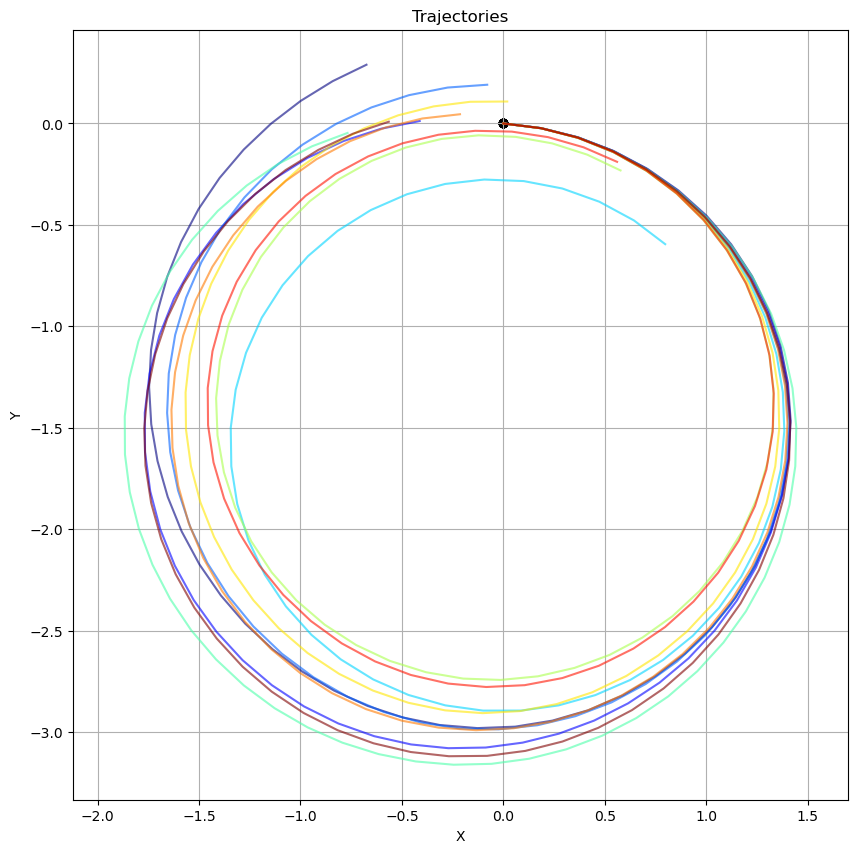

In [5]:
x_err, y_err, true_trajs, est_trajs = simulate(
    noise_velocity=0.005,
    drive_in_circles=True,
    episodes=10,
    steps=50,
    step_size_robot=0.25,
)

plot_trajectories(true_trajs, est_trajs)
# plot_final_position_histogram(x_err, y_err)

## c) We now introduce noise to the odometry (sensor) which leads to the estimation to be different compared to the correct pisition.

### i) The robot drives without taking the odometry into account and in a straight line

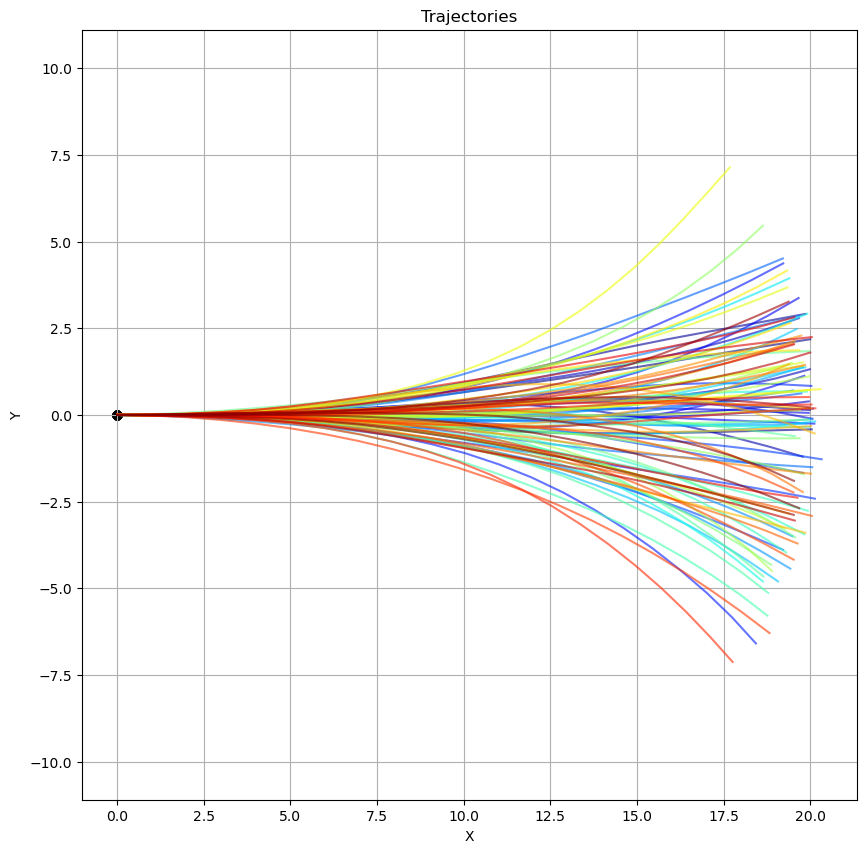

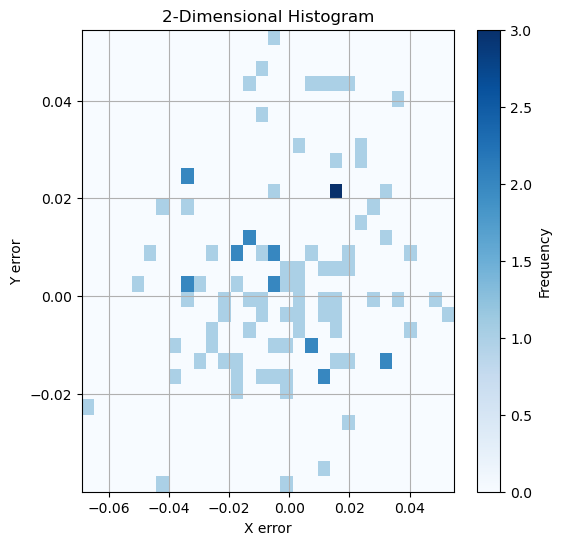

In [6]:
x_err, y_err, true_trajs, est_trajs = simulate(
    noise_velocity=0.005,
    noise_odometry=0.005,
    drive_in_circles=False,
    episodes=100,
    steps=20,
    step_size_robot=1,
)

plot_trajectories(true_trajs, est_trajs)
plot_final_position_histogram(x_err, y_err)

### i) The robot drives without taking the odometry into account and in a circle

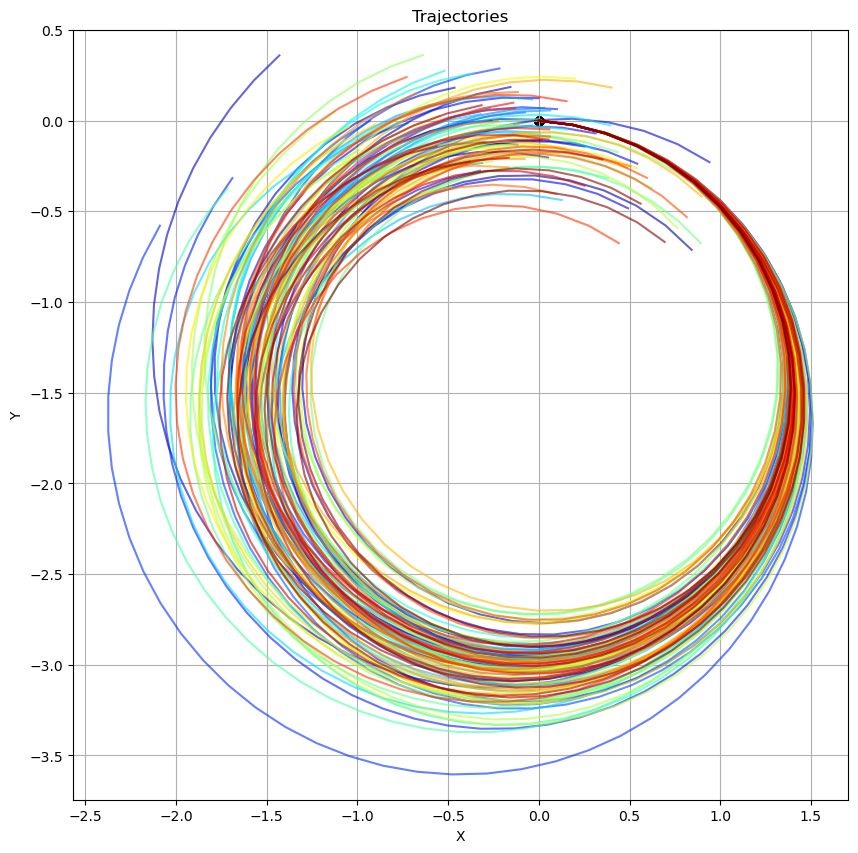

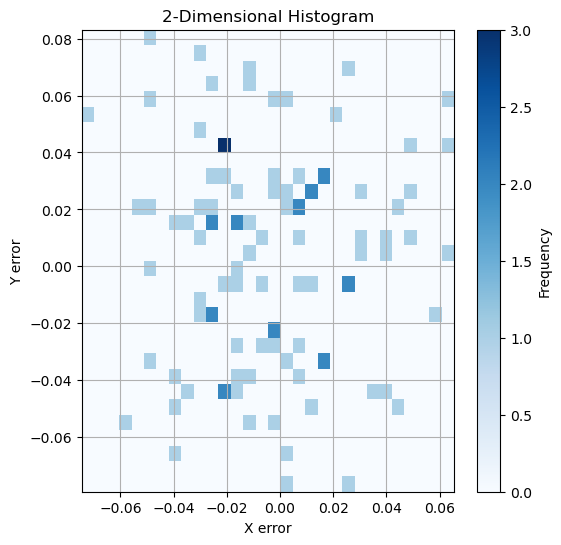

In [7]:
x_err, y_err, true_trajs, est_trajs = simulate(
    noise_velocity=0.005,
    noise_odometry=0.005,
    drive_in_circles=True,
    episodes=100,
    steps=50,
    step_size_robot=0.25,
)

plot_trajectories(true_trajs, est_trajs)
plot_final_position_histogram(x_err, y_err)

### ii) The robot makes corrections based on the perfect odometry estimation

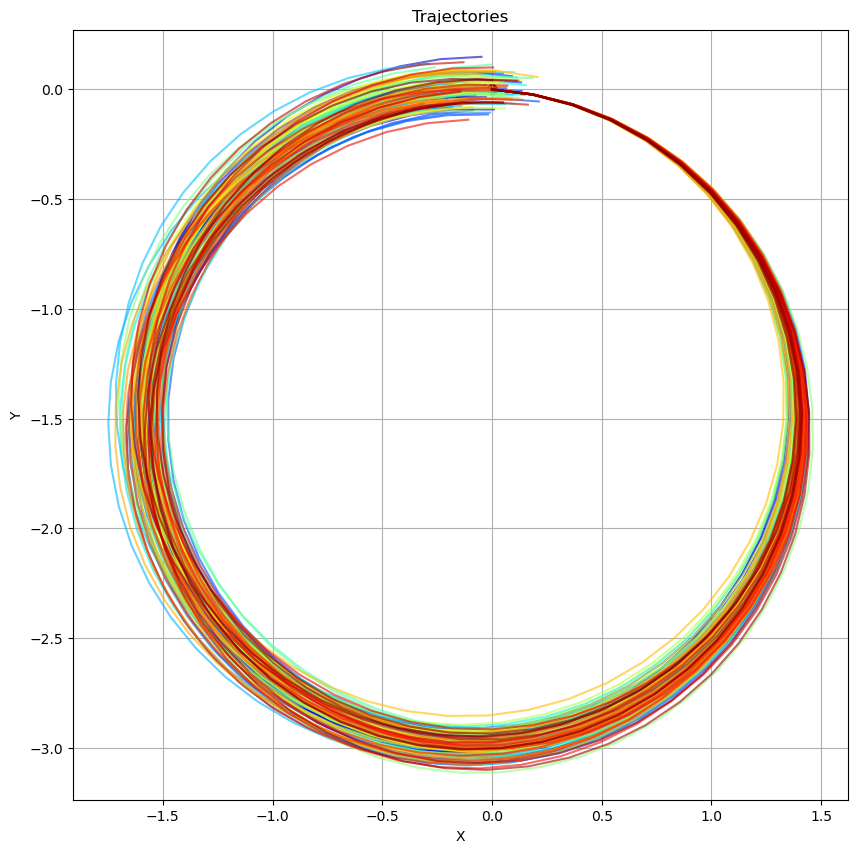

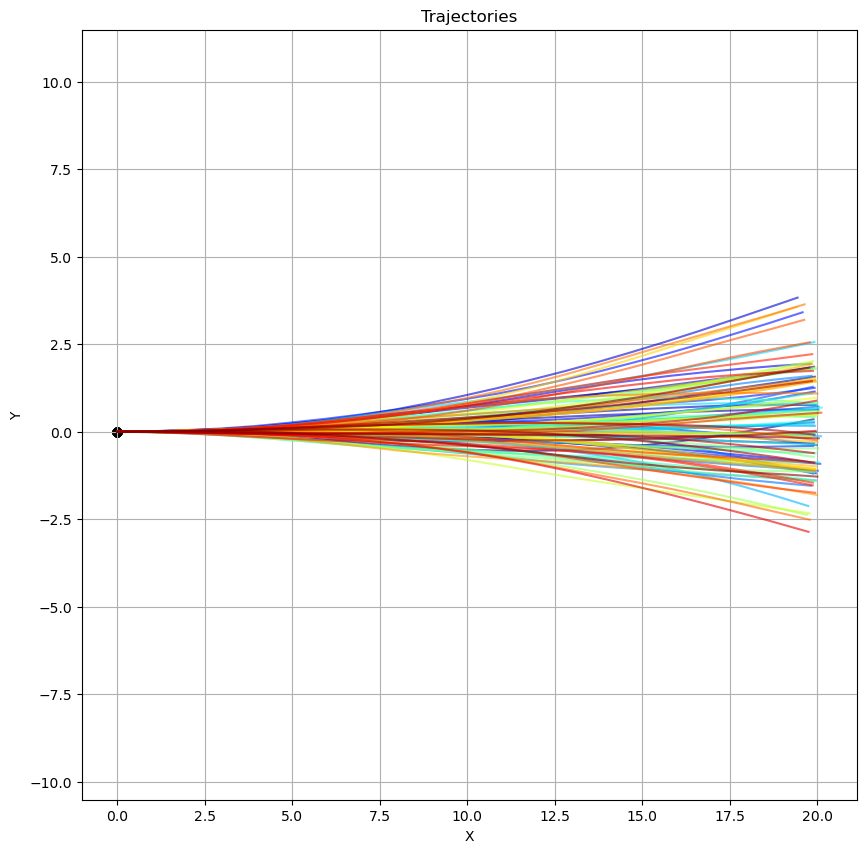

In [8]:
x_err, y_err, true_trajs, est_trajs = simulate(
    noise_velocity=0.005,
    noise_odometry=0,
    drive_in_circles=True,
    episodes=100,
    steps=50,
    step_size_robot=0.25,
    correction=True
)

plot_trajectories(true_trajs, est_trajs)
# plot_final_position_histogram(x_err, y_err)

x_err, y_err, true_trajs, est_trajs = simulate(
    noise_velocity=0.005,
    noise_odometry=0,
    drive_in_circles=False,
    episodes=100,
    steps=20,
    step_size_robot=1,
    correction=True
)

plot_trajectories(true_trajs, est_trajs)
# plot_final_position_histogram(x_err, y_err)

### iii) The robot makes corrections based on the noisy odometry estimation

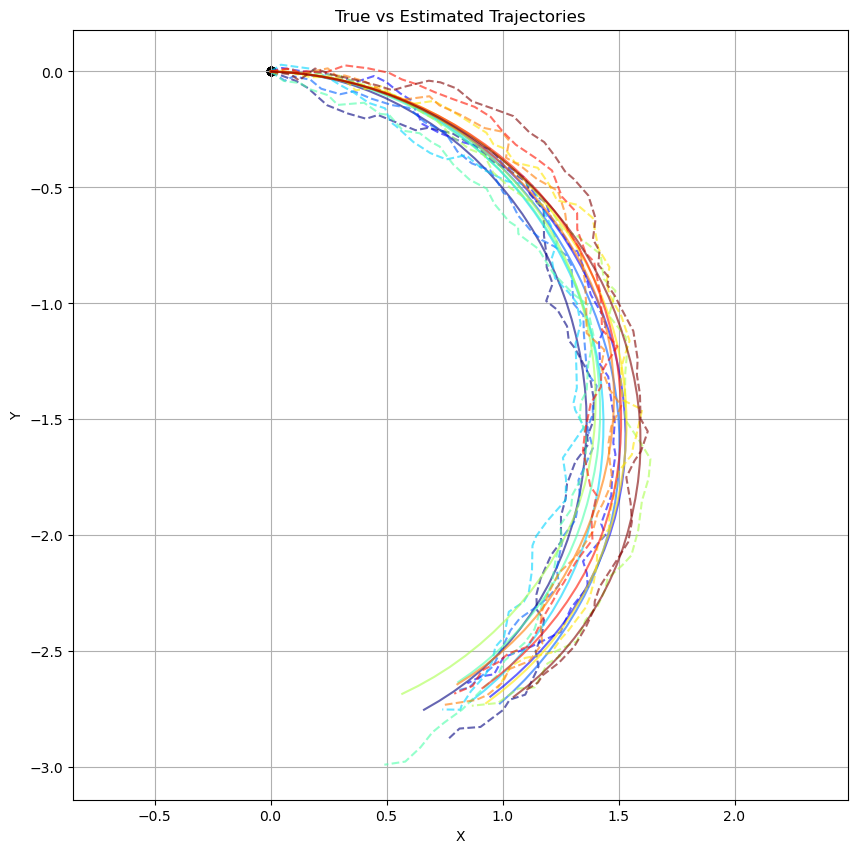

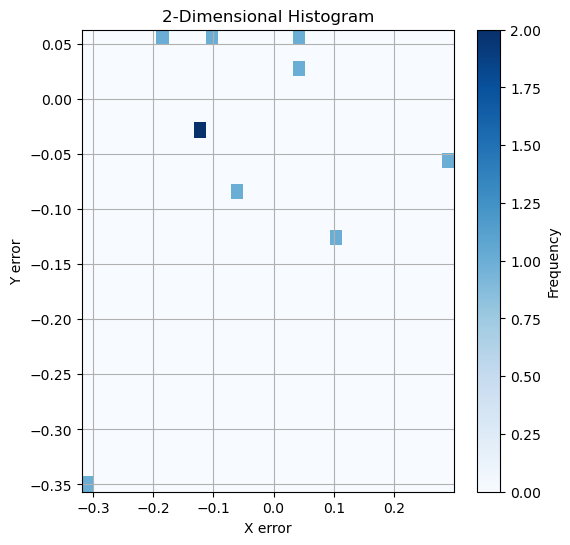

In [9]:
x_err, y_err, true_trajs, est_trajs = simulate(
    noise_velocity=0.005,
    noise_odometry=0.025,
    drive_in_circles=True,
    episodes=10,
    steps=50,
    step_size_robot=0.1,
    correction=True
)

plot_trajectories(true_trajs, est_trajs, show_estimate=True)
plot_final_position_histogram(x_err, y_err)



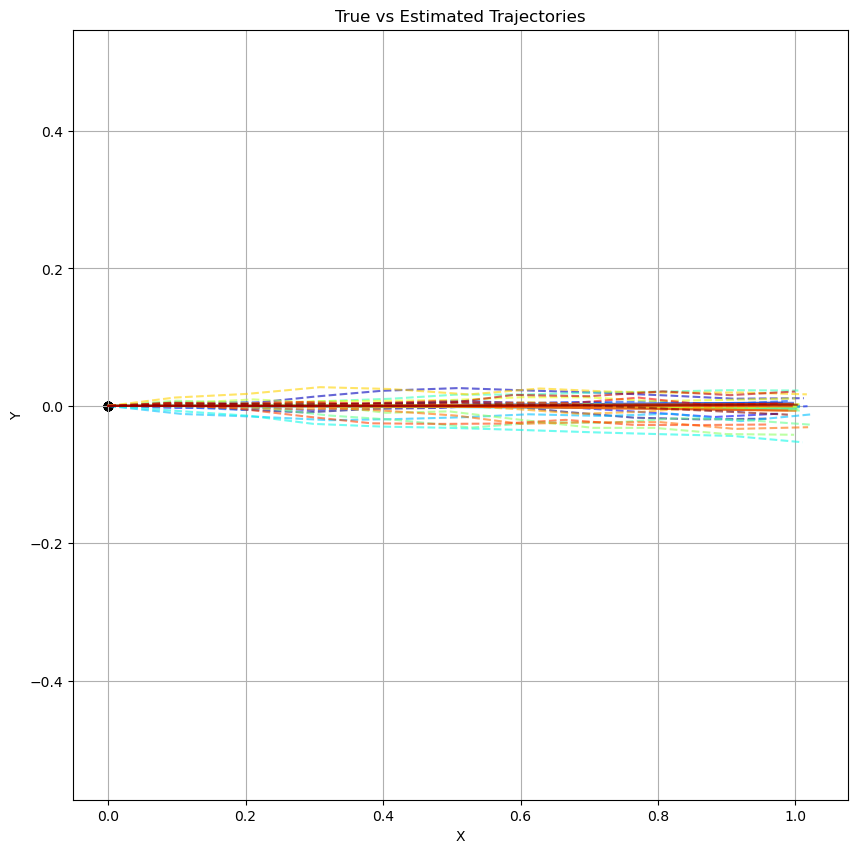

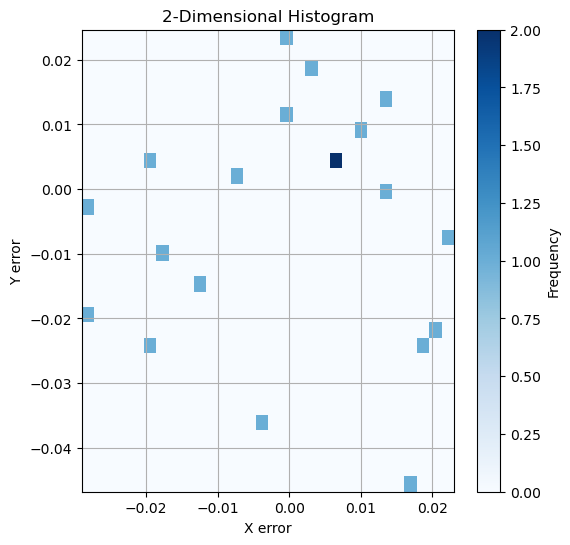

In [10]:
x_err, y_err, true_trajs, est_trajs = simulate(
    noise_velocity=0.005,
    noise_odometry=0.005,
    drive_in_circles=False,
    episodes=20,
    steps=10,
    step_size_robot=0.1,
    correction=True
)

plot_trajectories(true_trajs, est_trajs, show_estimate=True)
plot_final_position_histogram(x_err, y_err)